In [1]:
import numpy as np 
import pandas as pd 
import time 
import heapq

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
network = pd.read_csv('Network.csv')

In [3]:
starting_node = np.unique(network['FromNodeId'].values).tolist() #starting nodes
ending_node = np.unique(network['ToNodeId'].values).tolist() #ending nodes

In [4]:
# list of all nodes in graph
all_nodes_id = list(set(starting_node) | set(ending_node))

## 1.Implemnting Dijkstra Algorithm

In [6]:
# defininf graph as adjacency list which also contains travel time
graph = {}
for i in all_nodes_id:
    adj_node = np.array(network[network['FromNodeId']==i].ToNodeId.values).tolist()
    travel_time_adj_node = np.array(network[network['FromNodeId']==i].TravelTime.values).tolist()
    adj_node_travel_time = {key:value for key,value in zip(adj_node,travel_time_adj_node)}
    graph[i] = adj_node_travel_time

In [7]:
def dijkstra(graph, Source, Sink):
    
    distances = {vertex: float('infinity') for vertex in graph}  # distance from source node to each node
    # Initialization : distance from every node sets to infinity
    parent = {vertex: None for vertex in graph} # parent of each node in shortest path 
    # Initialization : parent of each node sets to None(NIL)
    
    
    distances[Source] = 0  # setting the distance for source node to 0 
    parent[Source] = None # setting the parent of source node to None(NIL)

    # Using priority queue for determining next node to get processed in each step 
    # For implementing the priority queue i use built-in heapq class
    # This class is based on Min-Heap data structue which is type of binary trees
    # The priority queue contains an object with its priority as integer value...
    ## In this algorithm nodes are object and their priority are their current distance estimation
    # At each step the nodes with the highest priority in queue(lowest distance value) get processed and leaves the priority queue
    # At each step nodes are added to priority queue and they sort based on their distance value in ascending order
    # Using this priority queue will dramarically decrease the running time of the algorithm
    # At the beginning of algorithm only the source node is in priority queue
    # we add nodes in form of tuple into the priority queue
    # the first element is the priority and the second element is node itself
    pq = [(0, Source)] 
    
    # The algorithm keeps visiting nodes until there's no node to visit 
    while len(pq) > 0:
        
        # As i said before in each step we visit the node based on their priority 
        # The current vertex is the node with lowest distance value 
        current_distance, current_vertex = heapq.heappop(pq)
        
        # If the visiting node is sink node, it means we already find the shortest path to sink node
        if current_vertex == Sink :
            break

        # Nodes can get added to the priority queue multiple times 
        # we only process a node the first time we remove it from the priority queue.
        if current_distance > distances[current_vertex]:
            continue
            
        # for each visiting node we consider its neighboring node 
        # to perform relax operation alongside its outgoing edges
        for neighbor, weight in graph[current_vertex].items():
            distance = current_distance + weight

            # Performing relax operation
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                parent[neighbor] = current_vertex
                # adding the neighboring node to the priority queue
                heapq.heappush(pq, (distance, neighbor))
                
    # affter finding shortest path to sink node, we keep back tracking the parent nodes in shortest path
    path = []
    node = Sink
    
    while node != Source:
        path.append(node)
        node = parent[node]
        
    path.append(Source)
    path = path[::-1]

    return distances[Sink], path


In [8]:
source = 2148
sink = 10123

In [11]:
start = time.time()
 
cost, path = dijkstra(graph,source,sink)

end = time.time()
print(end-start)

0.20184755325317383


In [12]:
cost

22738

In [16]:
print(path,sep='')

[2148, 1964, 2256, 1969, 1990, 1989, 1995, 1910, 2168, 2171, 2170, 2176, 2252, 2302, 2430, 2615, 2616, 2204, 2203, 2209, 2208, 2207, 2216, 2321, 2456, 2109, 2108, 2127, 2228, 2564, 2144, 2563, 2641, 5078, 3978, 3976, 3799, 3845, 3997, 5676, 4070, 3902, 3918, 3925, 1953, 7279, 7131, 7295, 7293, 7143, 7154, 7298, 7297, 7303, 7306, 7184, 7185, 7187, 7776, 7761, 7135, 7361, 8040, 7737, 7955, 7717, 7953, 7950, 7951, 8068, 7750, 11199, 9461, 9462, 7798, 7797, 7811, 7816, 7817, 7979, 464, 7998, 8018, 9906, 9905, 9903, 9902, 9900, 9899, 9898, 9985, 9984, 10071, 9910, 10080, 10077, 10279, 10204, 10116, 10203, 10201, 10200, 10197, 10193, 10206, 10123]


## 2.Incremental assignment

In [19]:
# In each step we update this data and we add flow column to it 
data = network.copy()

In [20]:
data['flow'] = 0

In [21]:
data.head(3)

,FromNodeId,ToNodeId,TravelTime,flow
0,0,1,376,0
1,0,2,486,0
2,0,29,401,0


In [22]:
## a function which updates travel and it consider flow capacity on edges
def update_tarvel_time(u, v, flow):
    t_ff = int(network[(network['FromNodeId']==u) & (network['ToNodeId']==v)].TravelTime.values)
    if flow >= 4000:
        updated_travel_time = float('infinity')
    else:
        updated_travel_time = t_ff*(1 + 0.3*((flow/4000)**2))
        
    return updated_travel_time

In [23]:
## a function which creates a graph from dataframe
def new_graph(df):
    graph = {}
    for i in all_nodes_id:
        adj_node = np.array(df[df['FromNodeId']==i].ToNodeId.values).tolist()
        travel_time_adj_node = np.array(df[df['FromNodeId']==i].TravelTime.values).tolist()
        adj_node_travel_time = {key:value for key,value in zip(adj_node,travel_time_adj_node)}
        graph[i] = adj_node_travel_time
    
    return graph

In [24]:
# a function that will update graph and data at each step given a path and increment

def update_graph(path, data, increment=1000):
    
    current_path = [[i,j] for i,j in zip(path[:-1], path[1:])]
    for edge in current_path :
        u = edge[0]
        v = edge[1]

        data.loc[(data['FromNodeId']==u) & (data['ToNodeId']==v), 'flow'] += increment
        flow = int(data[(data['FromNodeId']==u) & (data['ToNodeId']==v)].flow.values)
        data.loc[(data['FromNodeId']==u) & (data['ToNodeId']==v), 'TravelTime'] = update_tarvel_time(u=u, v=v, flow=flow)
    
    return new_graph(df=data),data

### Step 1. Finding the shortest path for assinging first 1000 vehicles

In [25]:
cost1, path1 = dijkstra(graph,source,sink)

In [26]:
cost1

22738

In [27]:
print(path1,sep='')

[2148, 1964, 2256, 1969, 1990, 1989, 1995, 1910, 2168, 2171, 2170, 2176, 2252, 2302, 2430, 2615, 2616, 2204, 2203, 2209, 2208, 2207, 2216, 2321, 2456, 2109, 2108, 2127, 2228, 2564, 2144, 2563, 2641, 5078, 3978, 3976, 3799, 3845, 3997, 5676, 4070, 3902, 3918, 3925, 1953, 7279, 7131, 7295, 7293, 7143, 7154, 7298, 7297, 7303, 7306, 7184, 7185, 7187, 7776, 7761, 7135, 7361, 8040, 7737, 7955, 7717, 7953, 7950, 7951, 8068, 7750, 11199, 9461, 9462, 7798, 7797, 7811, 7816, 7817, 7979, 464, 7998, 8018, 9906, 9905, 9903, 9902, 9900, 9899, 9898, 9985, 9984, 10071, 9910, 10080, 10077, 10279, 10204, 10116, 10203, 10201, 10200, 10197, 10193, 10206, 10123]


In [28]:
len(path1)

106

In [29]:
graph1, data = update_graph(path=path1, data=data, increment=1000)

### Step 2. Finding the shortest path for assinging the second 1000 vehicles

In [34]:
cost2, path2 = dijkstra(graph1,source,sink)

In [35]:
cost2

23124.825

In [36]:
print(path2,sep='')

[2148, 1964, 2256, 1969, 1990, 1989, 1995, 1910, 2168, 2171, 2170, 2176, 2252, 2302, 2430, 2615, 2616, 2450, 2657, 2621, 2618, 2619, 2528, 2526, 2527, 2645, 2642, 5068, 4188, 5076, 4244, 4243, 5129, 5128, 5132, 3841, 5159, 5157, 4037, 4035, 4074, 3929, 3928, 3930, 7127, 7297, 7303, 7306, 7184, 7185, 7187, 7776, 7761, 7135, 7361, 8040, 7737, 7955, 7717, 7953, 7950, 7951, 8068, 7750, 11199, 9461, 9462, 7798, 7797, 7811, 7816, 7817, 7979, 464, 7998, 8018, 9906, 9905, 9903, 9902, 9900, 9899, 9898, 9985, 9984, 10071, 9910, 10080, 10077, 10279, 10204, 10116, 10203, 10201, 10200, 10197, 10193, 10206, 10123]


In [37]:
len(path2)

99

In [38]:
graph2, data = update_graph(path=path2, data=data, increment=1000)

In [39]:
data['flow'].value_counts()

0       270430
2000        69
1000        65
Name: flow, dtype: int64

### Step 3. Finding the shortest path for assinging the third 1000 vehicles

In [79]:
cost3, path3 = dijkstra(graph2,source,sink)

In [80]:
cost3

23914.718749999996

In [42]:
print(path3,sep='')

[2148, 1964, 2256, 1969, 1990, 1989, 1995, 1910, 2178, 2181, 2183, 2185, 1794, 2201, 2067, 2200, 2215, 2226, 2117, 2116, 2111, 2129, 2229, 2134, 2127, 2228, 2564, 2144, 2563, 2641, 5078, 3978, 3976, 3799, 3845, 3997, 5676, 4070, 3902, 3918, 3925, 1953, 7279, 7131, 7295, 7293, 7143, 7154, 7298, 7297, 7303, 7306, 7184, 7185, 7187, 7776, 7761, 7135, 7361, 8040, 7737, 7955, 7717, 7953, 7950, 7951, 8068, 7750, 11199, 8232, 8233, 7799, 7797, 7811, 7816, 7817, 7979, 464, 7998, 8018, 9906, 9905, 9903, 9902, 9900, 9899, 9898, 9985, 9984, 10071, 9910, 10080, 10077, 10279, 10204, 10116, 10203, 10201, 10200, 10197, 10193, 10206, 10123]


In [43]:
len(path3)

103

In [44]:
graph3, data = update_graph(path=path3, data=data, increment=1000)

In [45]:
data['flow'].value_counts()

0       270409
1000        61
3000        56
2000        38
Name: flow, dtype: int64

### Step 4. Finding the shortest path for assinging the fourth 1000 vehicles

In [47]:
cost4, path4 = dijkstra(graph3,source,sink)

In [48]:
cost4

25138.949999999997

In [49]:
print(path4,sep='')

[2148, 1964, 2256, 1969, 1990, 1989, 1995, 1910, 1909, 1911, 2171, 2170, 2176, 2252, 2302, 2430, 2615, 2616, 2450, 2657, 2621, 2618, 2619, 2528, 2526, 2549, 2551, 5068, 4188, 5076, 4244, 4243, 5129, 5128, 5132, 3841, 5159, 5157, 4037, 4035, 4074, 3929, 3928, 3930, 7127, 7297, 7303, 7306, 7184, 7185, 7187, 7776, 7761, 7135, 7361, 8040, 7737, 7955, 7717, 7952, 8132, 8129, 8130, 8068, 7750, 11199, 8232, 8233, 7799, 7812, 7811, 7816, 7817, 7979, 464, 7998, 8018, 9906, 9905, 9903, 9902, 9916, 9818, 9817, 9815, 9833, 9838, 9845, 9844, 9929, 10214, 10210, 10212, 10203, 10201, 10200, 10197, 10193, 10206, 10123]


In [50]:
len(path4)

100

In [51]:
graph4, data = update_graph(path=path4, data=data, increment=1000)

In [52]:
data['flow'].value_counts()

0       270383
1000        59
2000        59
4000        38
3000        25
Name: flow, dtype: int64

### Step 5. Finding the shortest path for assinging the fifth 1000 vehicles

In [53]:
cost5, path5 = dijkstra(graph4,source,sink)

In [54]:
cost5

26113.0

In [55]:
print(path5,sep='')

[2148, 2150, 788, 655, 654, 737, 2573, 2576, 1917, 2325, 2587, 2584, 10761, 3444, 2667, 2668, 2672, 2397, 2596, 2374, 2373, 2389, 2427, 2712, 11142, 12059, 2603, 2601, 3021, 3030, 3029, 3035, 3039, 3050, 3052, 1343, 2934, 2931, 3118, 3064, 3065, 5766, 5769, 6392, 6400, 6404, 6417, 6493, 6433, 6494, 6495, 6453, 6497, 6499, 6459, 6728, 6242, 6241, 8397, 8449, 8448, 8486, 8485, 8491, 8812, 8513, 8511, 8512, 10903, 8568, 8566, 8589, 8606, 8605, 8607, 8612, 8637, 8638, 8636, 8658, 8667, 8668, 8684, 8908, 8909, 8907, 8911, 8724, 8723, 8725, 8726, 8761, 8941, 9189, 8978, 8977, 8805, 10235, 10234, 10238, 10178, 10199, 10094, 10102, 10195, 10124, 10123]


In [56]:
len(path5)

107

In [57]:
graph5, data = update_graph(path=path5, data=data, increment=1000)

In [58]:
data['flow'].value_counts()

0       270277
1000       165
2000        59
4000        38
3000        25
Name: flow, dtype: int64

### Step 6. Finding the shortest path for assinging the sixth 1000 vehicles

In [60]:
cost6, path6 = dijkstra(graph5,source,sink)

In [61]:
cost6

26602.618749999983

In [62]:
print(path6,sep='')

[2148, 2150, 788, 655, 654, 737, 2573, 2576, 1917, 2325, 2587, 2584, 10761, 3444, 2667, 2668, 2672, 2397, 2596, 2374, 2373, 2389, 2427, 2712, 11142, 12059, 2603, 2601, 3021, 3030, 3029, 3035, 3039, 3050, 3052, 1343, 2934, 2931, 3118, 3064, 3065, 5766, 5769, 6392, 6400, 6404, 6417, 6493, 6433, 6494, 6495, 6453, 6497, 6499, 6459, 6728, 6242, 6241, 8397, 8449, 8448, 8486, 8485, 8491, 8812, 8513, 8511, 8512, 10903, 8568, 8566, 8589, 8606, 8605, 8607, 8612, 8637, 8638, 8636, 8658, 8667, 8668, 8684, 8908, 8909, 8907, 8911, 8724, 8723, 8725, 8726, 8761, 8941, 9189, 8978, 8977, 8805, 10235, 10234, 10238, 10178, 10199, 10094, 10102, 10195, 10124, 10123]


In [63]:
len(path6)

107

In [64]:
graph6, data = update_graph(path=path6, data=data, increment=1000)

In [65]:
data['flow'].value_counts()

0       270277
2000       165
1000        59
4000        38
3000        25
Name: flow, dtype: int64

### Step 7. Finding the shortest path for assinging the seventh 1000 vehicles

In [66]:
cost7, path7 = dijkstra(graph6,source,sink)

In [67]:
cost7

27976.050000000007

In [68]:
print(path7, sep='')

[2148, 2150, 2328, 2339, 2338, 11103, 2576, 1917, 2325, 2587, 2584, 10761, 3444, 2667, 2668, 2672, 2397, 2596, 2374, 2373, 2389, 2427, 2712, 11142, 12059, 2603, 2601, 3021, 3030, 3029, 3035, 3039, 3050, 3052, 1343, 2934, 2931, 3118, 3064, 3065, 5766, 5769, 6392, 6400, 6404, 6417, 6493, 6433, 6494, 6495, 6453, 6497, 6499, 6459, 6728, 6242, 6241, 8397, 8449, 8448, 8486, 8485, 8491, 8812, 8565, 8564, 8568, 8566, 8589, 8606, 8605, 8588, 8612, 8637, 8638, 8636, 8658, 8667, 8668, 8684, 8908, 8909, 8907, 8911, 8724, 8723, 8725, 8726, 8761, 8941, 9189, 8978, 8977, 8805, 10235, 10234, 10238, 10178, 10199, 10094, 10102, 10195, 10124, 10123]


In [69]:
len(path7)

104

In [70]:
graph7, data = update_graph(path=path7, data=data, increment=1000)

In [72]:
data['flow'].value_counts()

0       270267
3000       118
2000        72
1000        69
4000        38
Name: flow, dtype: int64

### Step 8. Finding the shortest path for assinging the last 1000 vehicles

In [73]:
cost8, path8 = dijkstra(graph7,source,sink)

In [74]:
cost8

28496.725

In [75]:
print(path8, sep='')

[2148, 2150, 2328, 2339, 2340, 2660, 2659, 11104, 11105, 2247, 2248, 2169, 2002, 2254, 2176, 2252, 2302, 2430, 2615, 2616, 2450, 2657, 2621, 2618, 2619, 2528, 2526, 2527, 2645, 2642, 5068, 4188, 5076, 4244, 4243, 4242, 4245, 4264, 4271, 4277, 4276, 4281, 4286, 4295, 4294, 5196, 5270, 4353, 4352, 4350, 4359, 5203, 4403, 4401, 4434, 4494, 4493, 4500, 4534, 4561, 5347, 5349, 4809, 11046, 11212, 232, 5041, 7390, 7419, 7431, 7449, 7469, 7474, 8036, 7504, 7503, 7513, 7565, 7564, 8331, 8077, 8073, 7949, 7946, 7948, 7754, 7769, 7768, 1031, 515, 7788, 8678, 8679, 8922, 8724, 8723, 8725, 8726, 8761, 8941, 9189, 8978, 8977, 8805, 10235, 10234, 10238, 10178, 10199, 10094, 10102, 10195, 10124, 10123]


In [76]:
len(path8)

114

In [77]:
graph8, data = update_graph(path=path8, data=data, increment=1000)

In [78]:
data['flow'].value_counts()

0       270196
1000       134
3000       104
2000        67
4000        63
Name: flow, dtype: int64

In [84]:
import matplotlib.pyplot as plt

In [85]:
cost = [cost1,cost2,cost3,cost4,cost5,cost6,cost7,cost8]

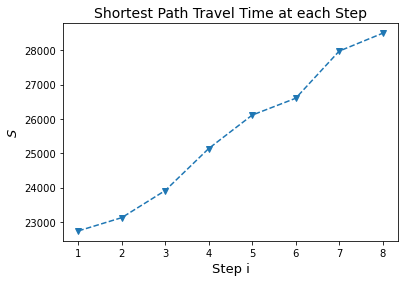

In [90]:
plt.plot(range(1,9), cost, marker='v', linestyle='--')
plt.xlabel('Step i', fontsize=13)
plt.ylabel('$S$', fontsize=13)
plt.title('Shortest Path Travel Time at each Step', fontsize=14)
plt.savefig('TT.png', dpi=1500)
plt.show()

In [91]:
data.to_csv('data.csv')

## Total travel time 

In [ ]:
#travel time 

In [ ]:
data.loc[data['flow'] == 4000, 'TravelTime']

In [92]:
# modifying the update travel time function for computing travel time at capacity
## a function which updates travel and it consider flow capacity on edges
def update_tarvel_time(u, v, flow):
    t_ff = int(network[(network['FromNodeId']==u) & (network['ToNodeId']==v)].TravelTime.values)
#     if flow > 4000:
#         updated_travel_time = float('infinity')
#     else:
    updated_travel_time = t_ff*(1 + 0.3*((flow/4000)**2))
        
    return updated_travel_time

In [93]:
data

,FromNodeId,ToNodeId,TravelTime,flow
0,0,1,376.0,0
1,0,2,486.0,0
2,0,29,401.0,0
3,1,0,298.0,0
4,1,23,249.0,0
...,...,...,...,...
270559,99999,100467,231.0,0
270560,99999,100468,513.0,0
270561,100026,99998,92.0,0
270562,100467,99999,515.0,0


In [101]:
data['TravelTime'] = data[['FromNodeId', 'ToNodeId', 'flow']].apply(lambda x : update_tarvel_time(u=x[0], v=x[1], flow=x[2]), axis=1)

In [ ]:
data.to_csv('revised_final_data.csv')

In [103]:
data['TravelTime'].value_counts()

54.00000     527
312.00000    522
23.00000     519
335.00000    514
226.00000    512
            ... 
212.71250      1
669.69375      1
406.48125      1
136.52500      1
20.80000       1
Name: TravelTime, Length: 925, dtype: int64

In [105]:
data['total_travel_time'] = data['TravelTime']*data['flow']/3600

In [106]:
data['total_travel_time'].sum()

63928.546875